# Module 06: Perceptron

**The First Neural Network Learning Algorithm**

---

## Objectives

By the end of this notebook, you will:
- Understand the perceptron model and algorithm
- Implement the perceptron learning algorithm from scratch
- Visualize the XOR problem and why single-layer perceptrons fail
- Understand how multi-layer perceptrons solve non-linear problems

**Prerequisites:**
- [Module 04 - The Neuron](../04_the_neuron/04_neuron.ipynb)
- [Module 05 - Activation Functions](../05_activation_functions/05_activation_functions.ipynb)

---

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

---

# Part 1: The Perceptron Model

---

## 1.1 Historical Context

The **perceptron** was invented by Frank Rosenblatt in 1958. It was the first algorithm that could learn from data, and it sparked enormous excitement about AI.

The New York Times wrote: "The Navy revealed the embryo of an electronic computer today that it expects will be able to walk, talk, see, write, reproduce itself and be conscious of its existence."

This excitement was short-lived when Minsky and Papert showed its limitations in 1969, leading to the first "AI Winter."

## 1.2 The Perceptron Architecture

A perceptron is a single neuron with a **step function** as activation:

$$z = \mathbf{w}^T \mathbf{x} + b = \sum_{i=1}^{n} w_i x_i + b$$

$$y = \begin{cases} 1 & \text{if } z \geq 0 \\ 0 & \text{if } z < 0 \end{cases}$$

The step function makes it a **binary classifier**.

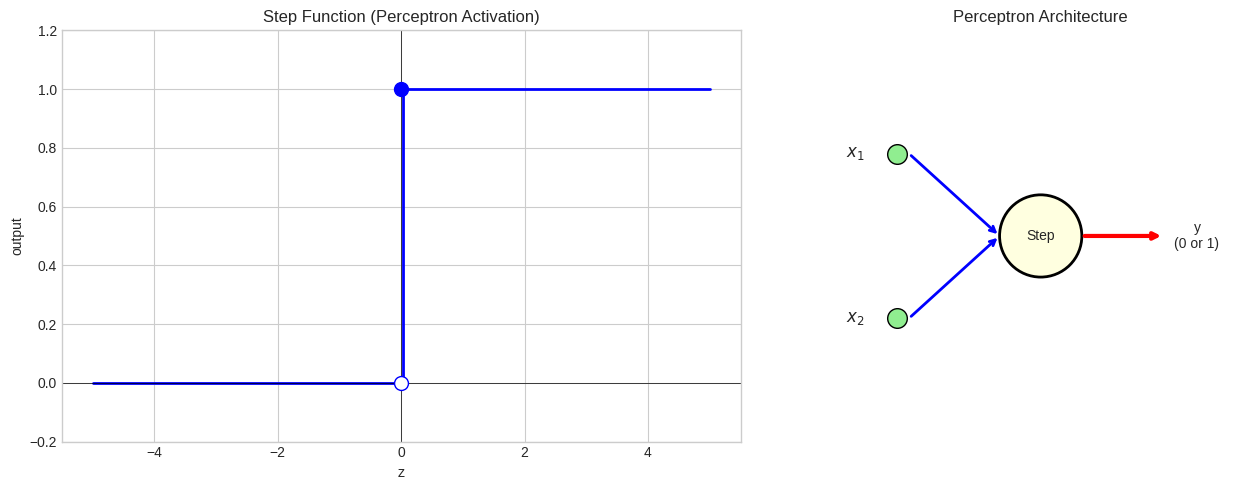

In [2]:
# Visualization: Perceptron
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Step function
ax = axes[0]
z = np.linspace(-5, 5, 200)
step = (z >= 0).astype(float)
ax.step(z, step, 'b-', linewidth=2, where='post')
ax.scatter([0], [1], color='blue', s=100, zorder=5)
ax.scatter([0], [0], color='blue', s=100, facecolors='white', edgecolors='blue', zorder=5)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('z')
ax.set_ylabel('output')
ax.set_title('Step Function (Perceptron Activation)')
ax.set_ylim(-0.2, 1.2)

# Perceptron diagram
ax = axes[1]
# Inputs
input_y = [0.7, 0.3]
for i, y in enumerate(input_y):
    ax.scatter([0.15], [y], s=200, c='lightgreen', edgecolors='black', zorder=5)
    ax.text(0.05, y, f'$x_{i+1}$', ha='center', va='center', fontsize=12)
    ax.annotate('', xy=(0.4, 0.5), xytext=(0.18, y),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2))

# Neuron
circle = plt.Circle((0.5, 0.5), 0.1, color='lightyellow', ec='black', linewidth=2)
ax.add_patch(circle)
ax.text(0.5, 0.5, 'Step', ha='center', va='center', fontsize=10)

# Output
ax.annotate('', xy=(0.8, 0.5), xytext=(0.6, 0.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=3))
ax.text(0.88, 0.5, 'y\n(0 or 1)', ha='center', va='center', fontsize=10)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Perceptron Architecture')

plt.tight_layout()
plt.show()

---

# Part 2: The Perceptron Learning Algorithm

---

## 2.1 The Algorithm

The perceptron learns by updating weights when it makes mistakes:

```
For each training example (x, y_true):
    1. Compute prediction: y_pred = step(w.x + b)
    2. If y_pred != y_true:
        w = w + learning_rate * (y_true - y_pred) * x
        b = b + learning_rate * (y_true - y_pred)
```

**Intuition:**
- If prediction is 0 but should be 1: increase weights (make z larger)
- If prediction is 1 but should be 0: decrease weights (make z smaller)

## 2.2 Implementation from Scratch

In [3]:
class Perceptron:
    """Perceptron classifier."""

    def __init__(self, n_features, learning_rate=0.1):
        self.weights = np.zeros(n_features)
        self.bias = 0.0
        self.lr = learning_rate
        self.errors_ = []  # Track errors per epoch

    def step(self, z):
        """Step activation function."""
        return np.where(z >= 0, 1, 0)

    def predict(self, X):
        """Predict class labels for samples in X."""
        z = np.dot(X, self.weights) + self.bias
        return self.step(z)

    def fit(self, X, y, n_epochs=100):
        """Train the perceptron."""
        for epoch in range(n_epochs):
            errors = 0
            for xi, yi in zip(X, y):
                # Predict
                y_pred = self.predict(xi)

                # Update if wrong
                update = self.lr * (yi - y_pred)
                self.weights += update * xi
                self.bias += update

                # Count errors
                errors += int(update != 0)

            self.errors_.append(errors)

            # Converged if no errors
            if errors == 0:
                print(f"Converged after {epoch + 1} epochs")
                break

        return self

## 2.3 Training on Linearly Separable Data

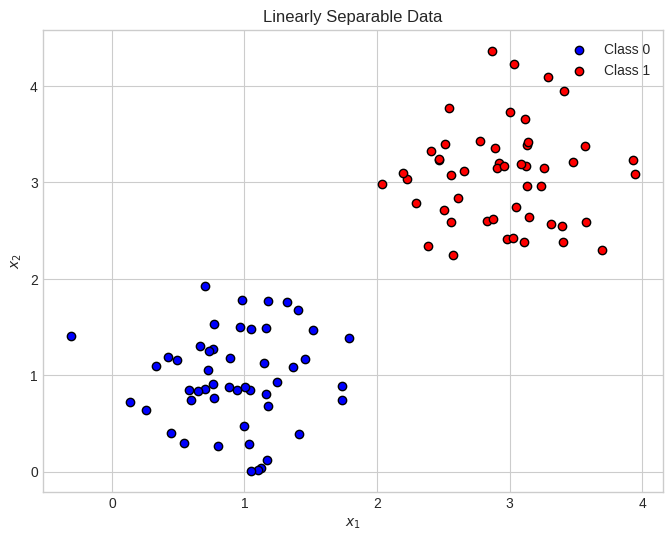

In [4]:
# Generate linearly separable data
np.random.seed(42)
n_samples = 50

# Class 0: centered at (1, 1)
X0 = np.random.randn(n_samples, 2) * 0.5 + [1, 1]
y0 = np.zeros(n_samples)

# Class 1: centered at (3, 3)
X1 = np.random.randn(n_samples, 2) * 0.5 + [3, 3]
y1 = np.ones(n_samples)

X = np.vstack([X0, X1])
y = np.hstack([y0, y1])

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X0[:, 0], X0[:, 1], color='blue', label='Class 0', edgecolors='k')
plt.scatter(X1[:, 0], X1[:, 1], color='red', label='Class 1', edgecolors='k')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Linearly Separable Data')
plt.legend()
plt.show()

In [5]:
# Train perceptron
perceptron = Perceptron(n_features=2, learning_rate=0.1)
perceptron.fit(X, y, n_epochs=100)

print(f"Learned weights: {perceptron.weights}")
print(f"Learned bias: {perceptron.bias}")

Converged after 13 epochs
Learned weights: [0.090253   0.32720201]
Learned bias: -0.8999999999999999


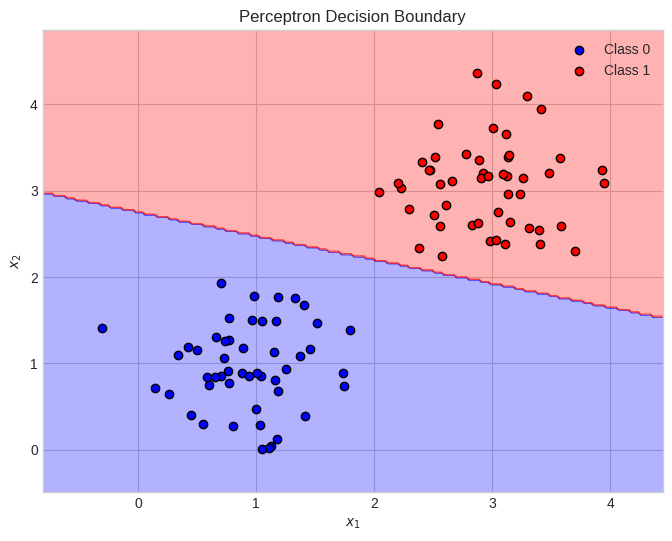

In [6]:
# Plot decision boundary
def plot_decision_boundary(model, X, y, title):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'red']))
    ax.scatter(X[y==0, 0], X[y==0, 1], color='blue', label='Class 0', edgecolors='k')
    ax.scatter(X[y==1, 0], X[y==1, 1], color='red', label='Class 1', edgecolors='k')

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(title)
    ax.legend()
    plt.show()

plot_decision_boundary(perceptron, X, y, 'Perceptron Decision Boundary')

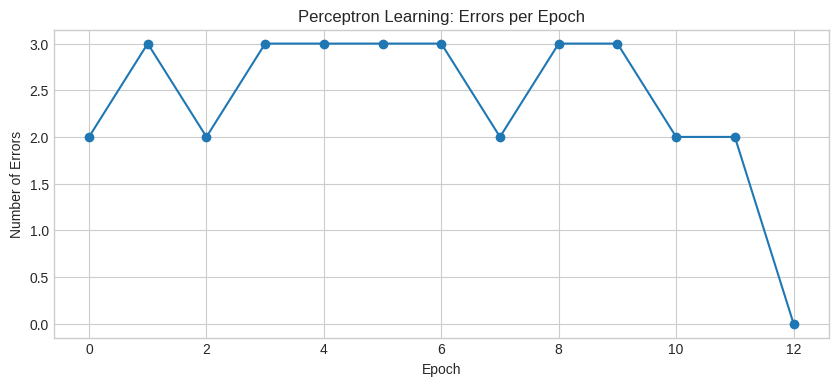

In [7]:
# Plot errors per epoch
plt.figure(figsize=(10, 4))
plt.plot(perceptron.errors_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Number of Errors')
plt.title('Perceptron Learning: Errors per Epoch')
plt.grid(True)
plt.show()

## 2.4 The Perceptron Convergence Theorem

**Theorem:** If the training data is linearly separable, the perceptron algorithm is guaranteed to converge to a solution (find a separating hyperplane) in a finite number of steps.

This was a remarkable result - the first proof that a machine could learn!

---

# Part 3: Logic Gates

---

## 3.1 AND, OR, NOT Gates

A single perceptron can learn simple logic gates.

In [8]:
# AND gate
X_and = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_and = np.array([0, 0, 0, 1])

perceptron_and = Perceptron(2, learning_rate=0.1)
perceptron_and.fit(X_and, y_and, n_epochs=100)

print("AND Gate:")
for xi, yi in zip(X_and, y_and):
    pred = perceptron_and.predict(xi)
    print(f"  {xi} -> {pred} (expected {yi})")

Converged after 4 epochs
AND Gate:
  [0 0] -> 0 (expected 0)
  [0 1] -> 0 (expected 0)
  [1 0] -> 0 (expected 0)
  [1 1] -> 1 (expected 1)


In [9]:
# OR gate
X_or = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_or = np.array([0, 1, 1, 1])

perceptron_or = Perceptron(2, learning_rate=0.1)
perceptron_or.fit(X_or, y_or, n_epochs=100)

print("OR Gate:")
for xi, yi in zip(X_or, y_or):
    pred = perceptron_or.predict(xi)
    print(f"  {xi} -> {pred} (expected {yi})")

Converged after 4 epochs
OR Gate:
  [0 0] -> 0 (expected 0)
  [0 1] -> 1 (expected 1)
  [1 0] -> 1 (expected 1)
  [1 1] -> 1 (expected 1)


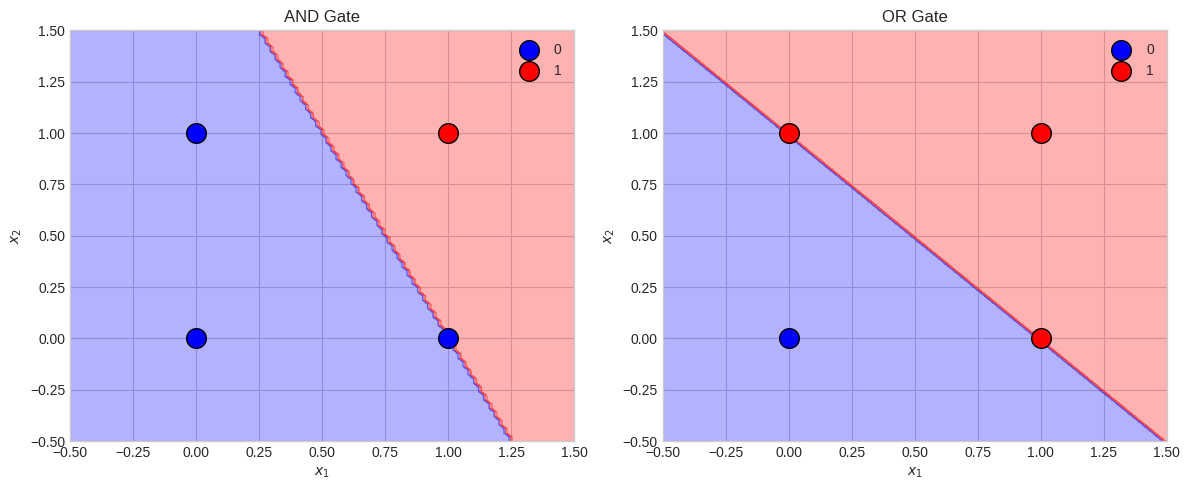

In [10]:
# Visualize AND and OR
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (name, X, y, model) in zip(axes, [('AND', X_and, y_and, perceptron_and),
                                           ('OR', X_or, y_or, perceptron_or)]):
    # Create mesh
    xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['blue', 'red']))
    ax.scatter(X[y==0, 0], X[y==0, 1], c='blue', s=200, edgecolors='k', label='0')
    ax.scatter(X[y==1, 0], X[y==1, 1], c='red', s=200, edgecolors='k', label='1')

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title(f'{name} Gate')
    ax.legend()

plt.tight_layout()
plt.show()

---

# Part 4: The XOR Problem

---

## 4.1 XOR is Not Linearly Separable

The XOR (exclusive or) function:
- (0, 0) -> 0
- (0, 1) -> 1
- (1, 0) -> 1
- (1, 1) -> 0

There is no single straight line that can separate the two classes!

In [11]:
# XOR gate
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([0, 1, 1, 0])

# Try to train perceptron on XOR
perceptron_xor = Perceptron(2, learning_rate=0.1)
perceptron_xor.fit(X_xor, y_xor, n_epochs=100)

print("XOR Gate (Perceptron FAILS):")
for xi, yi in zip(X_xor, y_xor):
    pred = perceptron_xor.predict(xi)
    status = "correct" if pred == yi else "WRONG"
    print(f"  {xi} -> {pred} (expected {yi}) {status}")

XOR Gate (Perceptron FAILS):
  [0 0] -> 1 (expected 0) WRONG
  [0 1] -> 1 (expected 1) correct
  [1 0] -> 0 (expected 1) WRONG
  [1 1] -> 0 (expected 0) correct


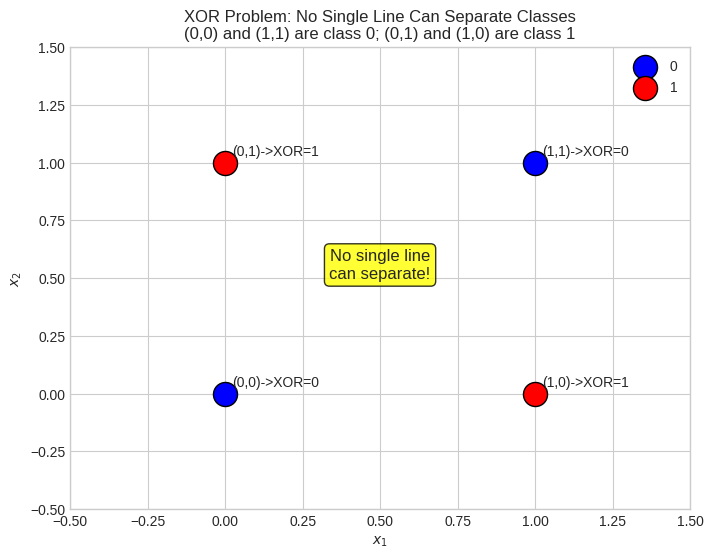

In [12]:
# Visualize why XOR fails
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(X_xor[y_xor==0, 0], X_xor[y_xor==0, 1], c='blue', s=300, edgecolors='k', label='0')
ax.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='red', s=300, edgecolors='k', label='1')

# Annotate points
for i, (x, y) in enumerate(X_xor):
    ax.annotate(f'({x},{y})->XOR={y_xor[i]}', (x, y), xytext=(5, 5),
                textcoords='offset points', fontsize=10)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('XOR Problem: No Single Line Can Separate Classes\n(0,0) and (1,1) are class 0; (0,1) and (1,0) are class 1')
ax.legend()
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)

# Show that no line works
ax.annotate('No single line\ncan separate!', xy=(0.5, 0.5), fontsize=12, ha='center',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.show()

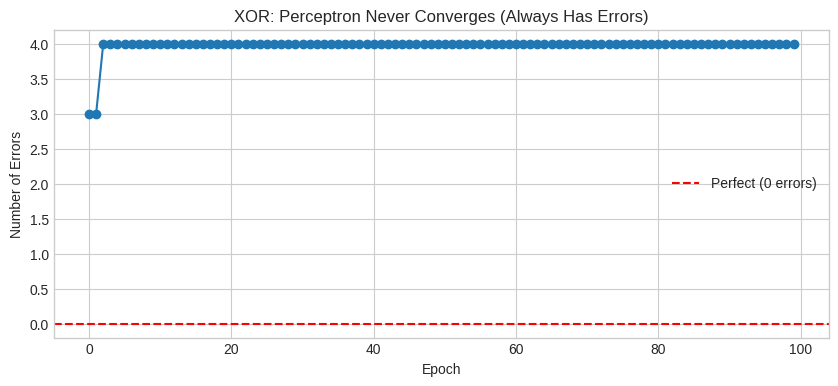

In [13]:
# Show perceptron never converges on XOR
plt.figure(figsize=(10, 4))
plt.plot(perceptron_xor.errors_, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Number of Errors')
plt.title('XOR: Perceptron Never Converges (Always Has Errors)')
plt.axhline(y=0, color='r', linestyle='--', label='Perfect (0 errors)')
plt.legend()
plt.grid(True)
plt.show()

## 4.2 Historical Impact

In 1969, Marvin Minsky and Seymour Papert published "Perceptrons", which mathematically proved that single-layer perceptrons cannot solve XOR or any non-linearly separable problem.

This was devastating because many real-world problems are not linearly separable. Funding dried up, and the first "AI Winter" began.

**The solution was known even then: use multiple layers!** But training multi-layer networks was difficult until backpropagation became popular in the 1980s.

---

# Part 5: Multi-Layer Perceptron (MLP)

---

## 5.1 The Solution: Add Hidden Layers

By adding a hidden layer, we can learn non-linear decision boundaries.

**How XOR can be solved:**

XOR(a, b) = OR(AND(a, NOT b), AND(NOT a, b))

This requires two hidden neurons!

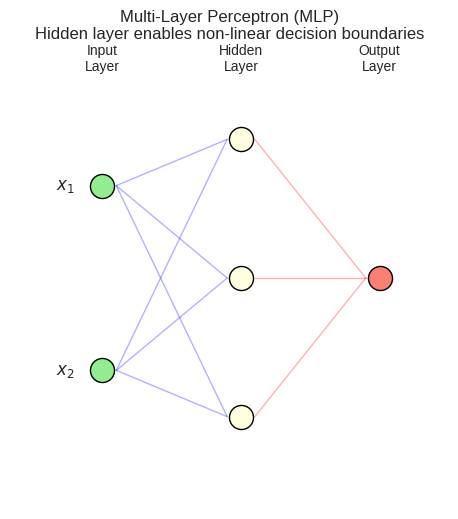

In [14]:
# Visualize MLP architecture for XOR
fig, ax = plt.subplots(figsize=(12, 6))

# Input layer
for i, y in enumerate([0.7, 0.3]):
    ax.scatter([0.1], [y], s=300, c='lightgreen', edgecolors='black', zorder=5)
    ax.text(0.02, y, f'$x_{i+1}$', ha='center', va='center', fontsize=12)

# Hidden layer
for i, y in enumerate([0.8, 0.5, 0.2]):
    ax.scatter([0.4], [y], s=300, c='lightyellow', edgecolors='black', zorder=5)
    ax.text(0.4, y, f'$h_{i+1}$', ha='center', va='center', fontsize=10)

# Output layer
ax.scatter([0.7], [0.5], s=300, c='salmon', edgecolors='black', zorder=5)
ax.text(0.7, 0.5, 'y', ha='center', va='center', fontsize=12)

# Connections input to hidden
for iy in [0.7, 0.3]:
    for hy in [0.8, 0.5, 0.2]:
        ax.plot([0.13, 0.37], [iy, hy], 'b-', alpha=0.3, linewidth=1)

# Connections hidden to output
for hy in [0.8, 0.5, 0.2]:
    ax.plot([0.43, 0.67], [hy, 0.5], 'r-', alpha=0.3, linewidth=1)

# Labels
ax.text(0.1, 0.95, 'Input\nLayer', ha='center', fontsize=10)
ax.text(0.4, 0.95, 'Hidden\nLayer', ha='center', fontsize=10)
ax.text(0.7, 0.95, 'Output\nLayer', ha='center', fontsize=10)

ax.set_xlim(-0.1, 0.85)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Multi-Layer Perceptron (MLP)\nHidden layer enables non-linear decision boundaries', fontsize=12)
plt.show()

## 5.2 Solving XOR with PyTorch MLP

In [15]:
# XOR data
X_xor_t = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
y_xor_t = torch.tensor([[0.], [1.], [1.], [0.]])

# MLP with one hidden layer
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4)   # Hidden layer with 4 neurons
        self.fc2 = nn.Linear(4, 1)   # Output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)      # Non-linearity!
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Train
mlp = MLP()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.1)

losses = []
for epoch in range(1000):
    pred = mlp(X_xor_t)
    loss = criterion(pred, y_xor_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.6824
Epoch 200: Loss = 0.0019
Epoch 400: Loss = 0.0007
Epoch 600: Loss = 0.0004
Epoch 800: Loss = 0.0002


In [16]:
# Test the MLP on XOR
print("\nXOR Results with MLP:")
with torch.no_grad():
    predictions = mlp(X_xor_t)
    for xi, yi, pi in zip(X_xor_t, y_xor_t, predictions):
        pred_class = 1 if pi.item() > 0.5 else 0
        print(f"  {xi.tolist()} -> {pi.item():.3f} (class {pred_class}, expected {int(yi.item())})")


XOR Results with MLP:
  [0.0, 0.0] -> 0.000 (class 0, expected 0)
  [0.0, 1.0] -> 1.000 (class 1, expected 1)
  [1.0, 0.0] -> 1.000 (class 1, expected 1)
  [1.0, 1.0] -> 0.000 (class 0, expected 0)


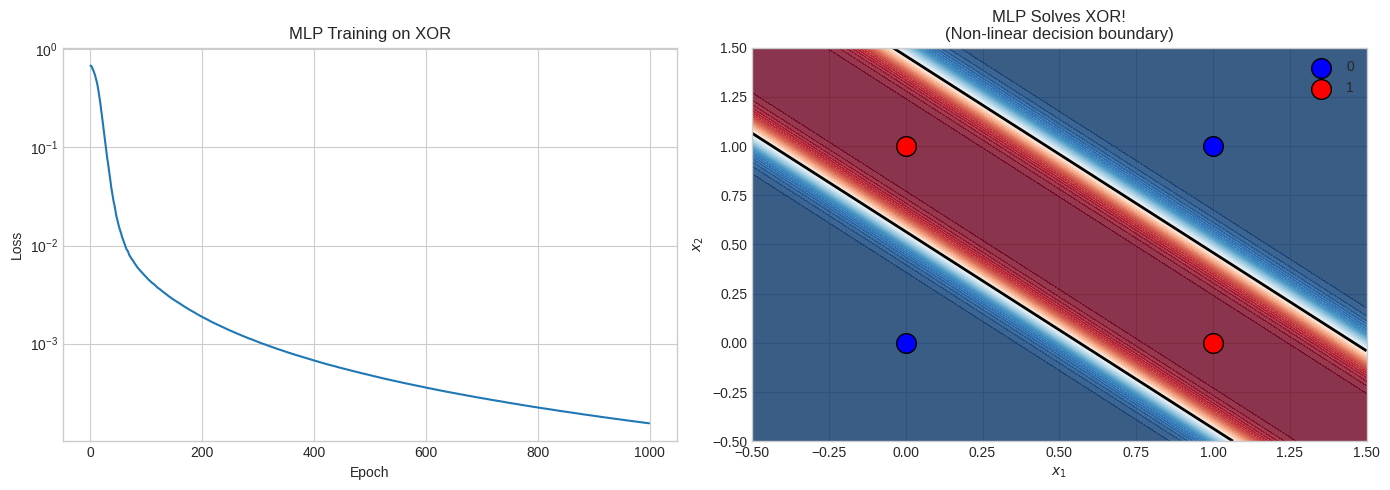

In [17]:
# Visualize MLP decision boundary for XOR
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
axes[0].plot(losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('MLP Training on XOR')
axes[0].set_yscale('log')

# Decision boundary
ax = axes[1]
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    Z = mlp(grid).numpy().reshape(xx.shape)

ax.contourf(xx, yy, Z, levels=50, cmap='RdBu_r', alpha=0.8)
ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
ax.scatter(X_xor[y_xor==0, 0], X_xor[y_xor==0, 1], c='blue', s=200, edgecolors='k', label='0')
ax.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='red', s=200, edgecolors='k', label='1')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('MLP Solves XOR!\n(Non-linear decision boundary)')
ax.legend()

plt.tight_layout()
plt.show()

## 5.3 How Does the Hidden Layer Help?

The hidden layer transforms the input space into a new space where the problem becomes linearly separable.

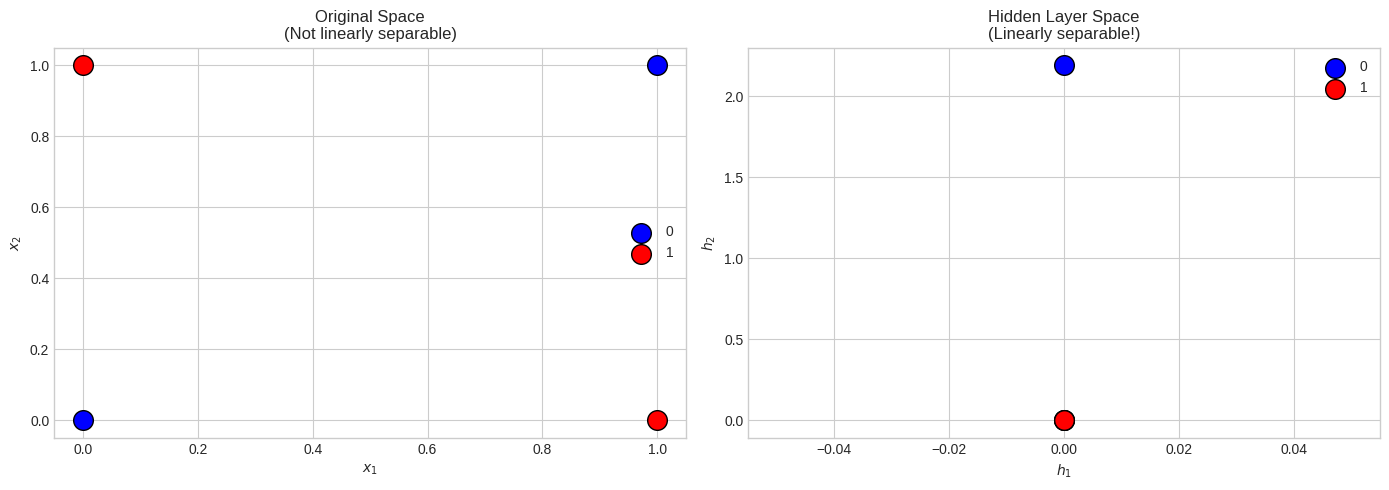

In [18]:
# Visualize the hidden layer representation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original space
ax = axes[0]
ax.scatter(X_xor[y_xor==0, 0], X_xor[y_xor==0, 1], c='blue', s=200, edgecolors='k', label='0')
ax.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='red', s=200, edgecolors='k', label='1')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Original Space\n(Not linearly separable)')
ax.legend()

# Hidden space
ax = axes[1]
with torch.no_grad():
    hidden = torch.relu(mlp.fc1(X_xor_t))  # Get hidden layer outputs

# Use first two hidden dimensions for visualization
h = hidden.numpy()
ax.scatter(h[y_xor==0, 0], h[y_xor==0, 1], c='blue', s=200, edgecolors='k', label='0')
ax.scatter(h[y_xor==1, 0], h[y_xor==1, 1], c='red', s=200, edgecolors='k', label='1')
ax.set_xlabel('$h_1$')
ax.set_ylabel('$h_2$')
ax.set_title('Hidden Layer Space\n(Linearly separable!)')
ax.legend()

plt.tight_layout()
plt.show()

---

# Key Points Summary

---

## The Perceptron
- Single neuron with step activation
- Learns by updating weights when wrong
- Guaranteed to converge for linearly separable data

## Limitations
- Can only learn linearly separable patterns
- Cannot solve XOR (proved by Minsky & Papert)
- This limitation led to the first AI Winter

## Multi-Layer Perceptron
- Adding hidden layers enables non-linear boundaries
- Hidden layers transform input to a separable space
- Foundation of modern deep learning

---

# Interview Tips

---

## Common Questions

**Q: What is a perceptron?**
A: A perceptron is a single-layer neural network with a step activation function. It computes a weighted sum of inputs, adds a bias, and outputs 1 if the result is positive, 0 otherwise.

**Q: What is the XOR problem?**
A: XOR is a classic example of a non-linearly separable problem that single-layer perceptrons cannot solve. The inputs (0,0) and (1,1) map to 0, while (0,1) and (1,0) map to 1. No single straight line can separate these classes.

**Q: How do you solve the XOR problem?**
A: By using a multi-layer perceptron (MLP) with at least one hidden layer. The hidden layer transforms the input space into a new representation where the classes become linearly separable.

**Q: What is the perceptron convergence theorem?**
A: It states that if the training data is linearly separable, the perceptron learning algorithm will converge to a solution in a finite number of steps.

---

# Practice Exercises

---

## Exercise 1: Implement NAND Gate

Train a perceptron to learn NAND (NOT AND):
- (0,0) -> 1
- (0,1) -> 1  
- (1,0) -> 1
- (1,1) -> 0

In [19]:
# Your code here
X_nand = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_nand = np.array([1, 1, 1, 0])

# Train perceptron

## Exercise 2: Visualize Decision Boundary Animation

Modify the Perceptron class to store weights at each epoch and visualize how the decision boundary evolves during training.

In [20]:
# Your code here

## Solutions

In [21]:
# Exercise 1 Solution
print("Exercise 1: NAND Gate")
X_nand = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_nand = np.array([1, 1, 1, 0])

perceptron_nand = Perceptron(2, learning_rate=0.1)
perceptron_nand.fit(X_nand, y_nand, n_epochs=100)

print("NAND Gate:")
for xi, yi in zip(X_nand, y_nand):
    pred = perceptron_nand.predict(xi)
    print(f"  {xi} -> {pred} (expected {yi})")

Exercise 1: NAND Gate
Converged after 6 epochs
NAND Gate:
  [0 0] -> 1 (expected 1)
  [0 1] -> 1 (expected 1)
  [1 0] -> 1 (expected 1)
  [1 1] -> 0 (expected 0)


---

## Next Module: [07 - Loss Functions](../07_loss_functions/07_loss_functions.ipynb)

Now that we understand the limitations of simple perceptrons and how MLPs can overcome them, let's dive into loss functions - how we measure model error.